In [18]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge


In [19]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("toyota_project")

<Experiment: artifact_location='mlflow-artifacts:/833447958012810940', creation_time=1747431455974, experiment_id='833447958012810940', last_update_time=1747431455974, lifecycle_stage='active', name='toyota_project', tags={}>

In [20]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)

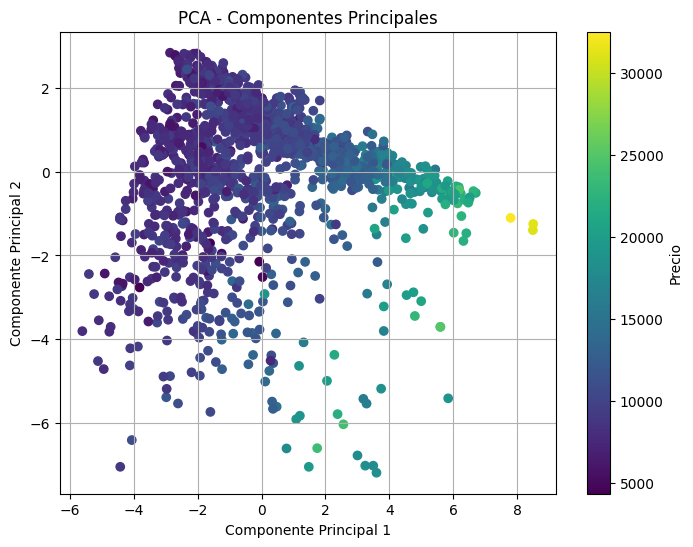

Varianza explicada por componente:
[0.18524967 0.09128984 0.07757968]


In [21]:
numeric_features = df.select_dtypes(include=["int64", "float64"])

# 1. Estandarizar las features (sin incluir 'Price' porque es la target)
X = numeric_features.drop(columns="Price")
y = numeric_features["Price"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Aplicar PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# 3. Visualizar
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar(label="Precio")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA - Componentes Principales")
plt.grid(True)
plt.show()

print("Varianza explicada por componente:")
print(pca.explained_variance_ratio_)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Price                1436 non-null   int64
 1   Age_08_04_calculado  1436 non-null   int64
 2   KM                   1436 non-null   int64
 3   cc                   1436 non-null   int64
 4   Doors                1436 non-null   int64
 5   Weight               1436 non-null   int64
 6   Quarterly_Tax        1436 non-null   int64
dtypes: int64(7)
memory usage: 78.7 KB


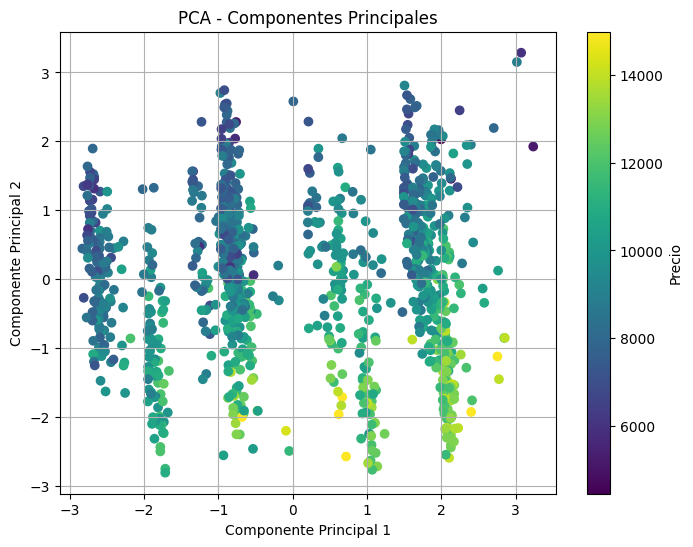

Varianza explicada por componente:
[0.45265698 0.23779129]


In [ ]:
# =========================
# 1. EXPLORACIÓN DE DATOS
# =========================
df["Age_08_04_calculado"] = (2004 - df["Mfg_Year"]) * 12 + (8 - df["Mfg_Month"])

features_selected = ["Price", "Age_08_04_calculado", "KM", "cc", "Doors", "Weight","Quarterly_Tax"]

df_selected = df[features_selected].copy()

df_selected.info()

df_selected.describe()

df_selected.describe().T

df_selected.head()


# 👉 Filtro por sentido común / dominio
df_selected = df_selected[
    (df_selected["Price"] > 1000) & (df_selected["Price"] < 15000) &
    (df_selected["Age_08_04_calculado"] > 30) & (df_selected["Age_08_04_calculado"] < 80) &
    (df_selected["KM"] > 0) & (df_selected["KM"] < 140000) &
    (df_selected["cc"] > 600) & (df_selected["cc"] < 2500) &
    (df_selected["Weight"] > 800) & (df_selected["Weight"] < 1200) &
    (df_selected["Doors"].isin([3, 4, 5])) &
    (df_selected["Quarterly_Tax"] > 30) & (df_selected["Quarterly_Tax"] < 120)
]

# 1. Estandarizar las features (sin incluir 'Price' porque es la target)
X = df_selected.drop(columns="Price")
y = df_selected["Price"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Visualizar
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar(label="Precio")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA - Componentes Principales")
plt.grid(True)
plt.show()

print("Varianza explicada por componente:")
print(pca.explained_variance_ratio_)



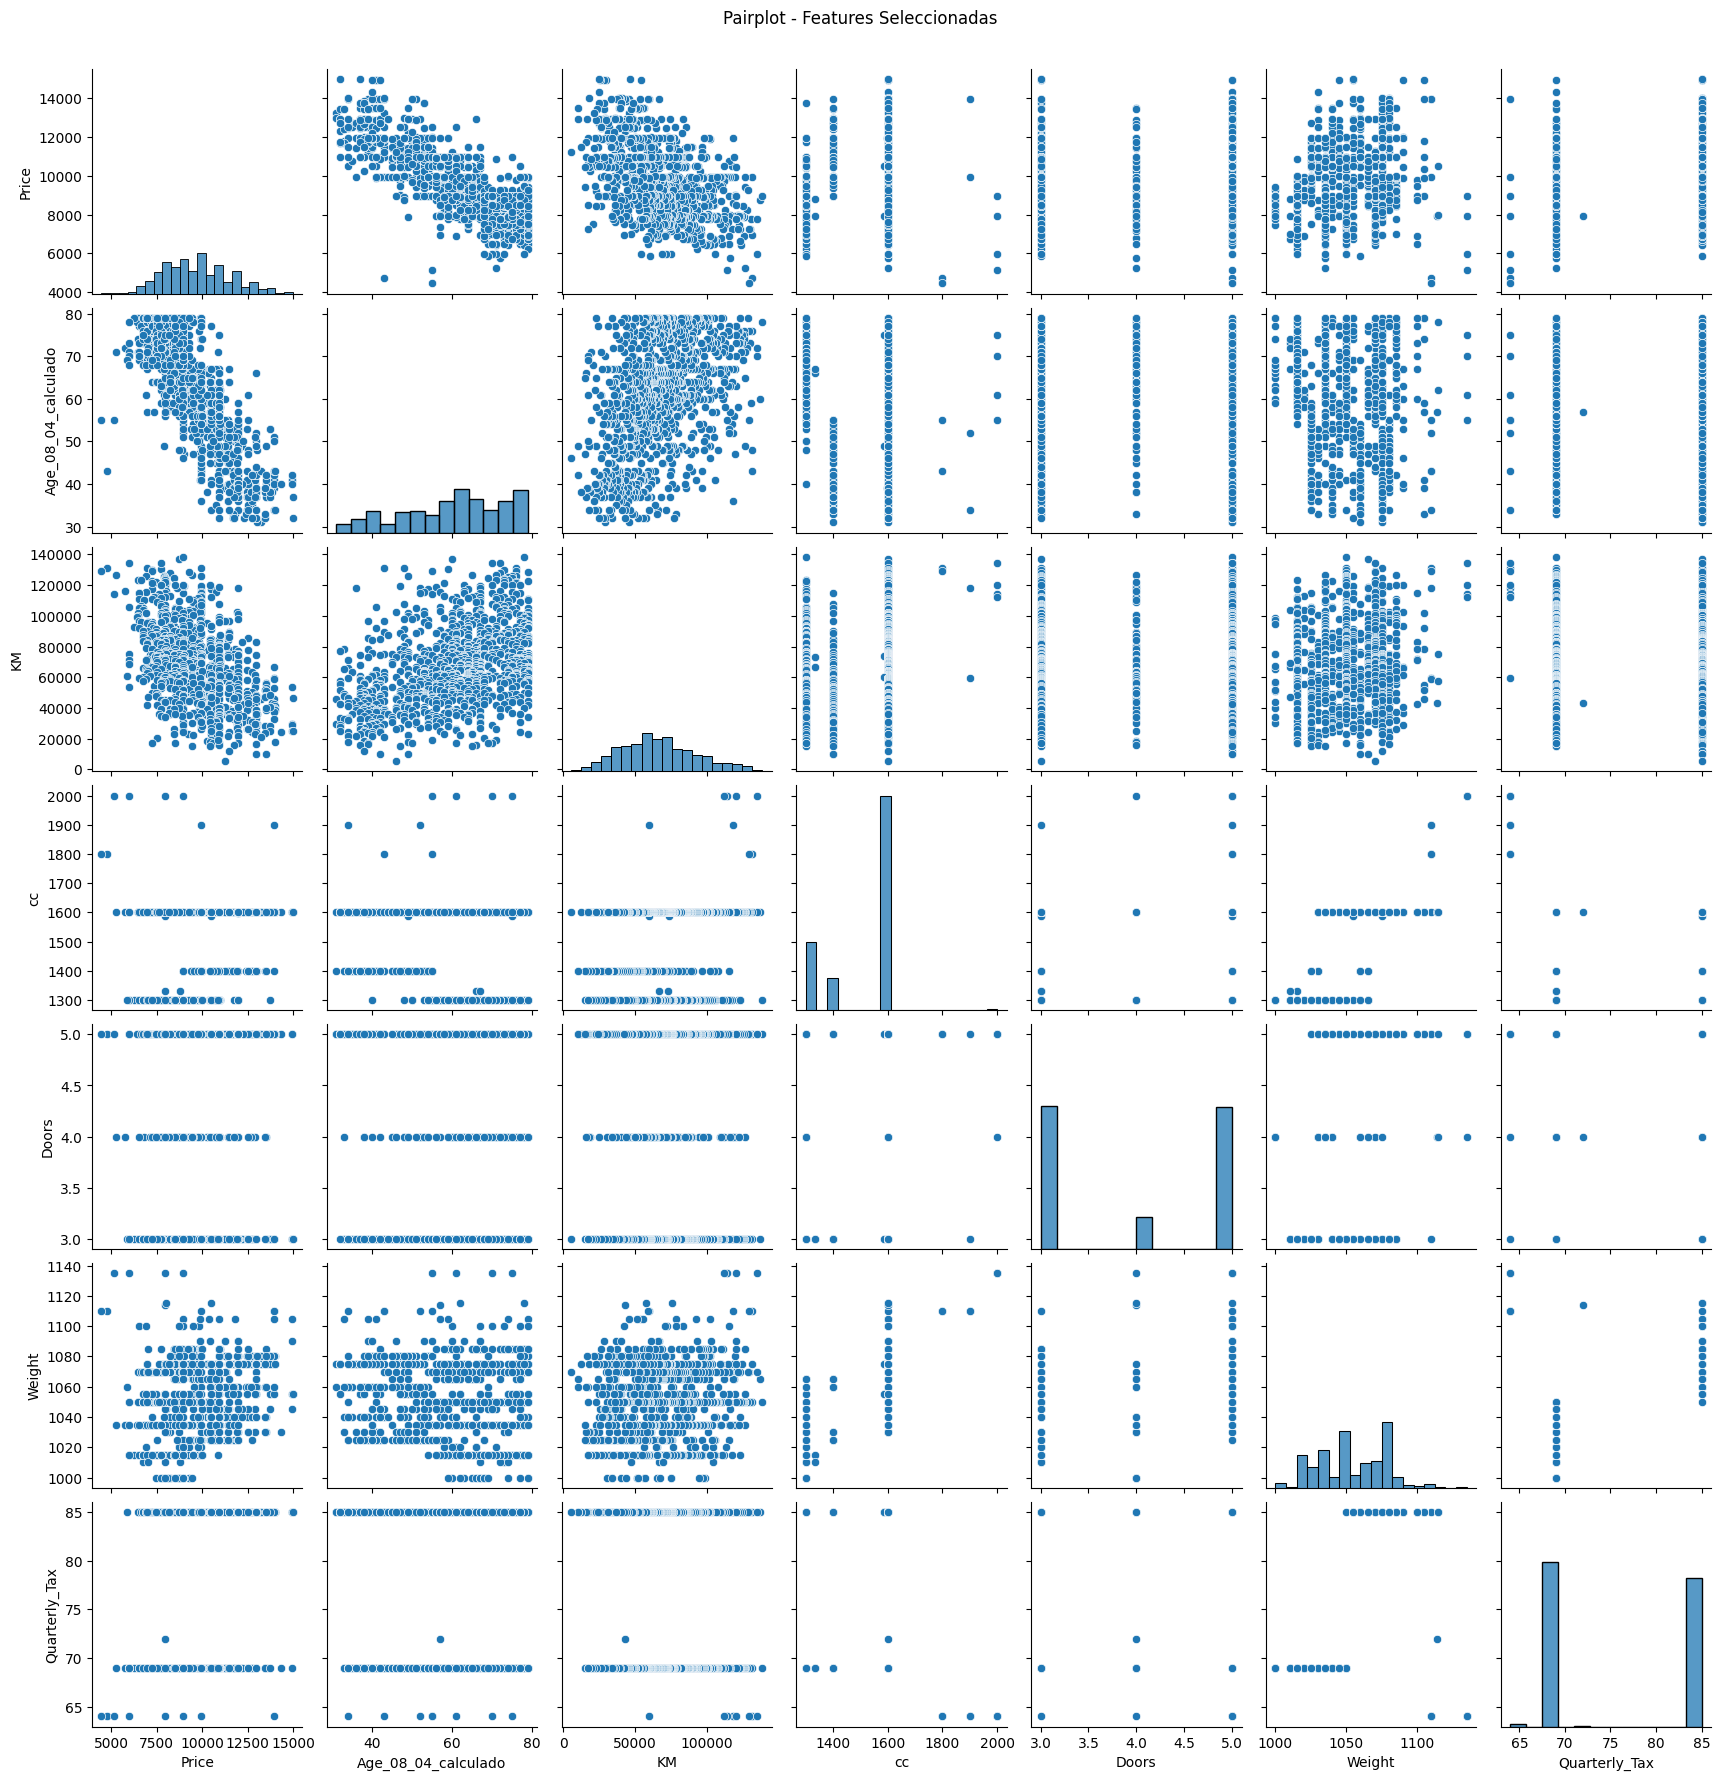

In [23]:
# Pairplot
sns.pairplot(data=df_selected.select_dtypes(include=np.number))
plt.suptitle("Pairplot - Features Seleccionadas", y=1.02)
plt.show()

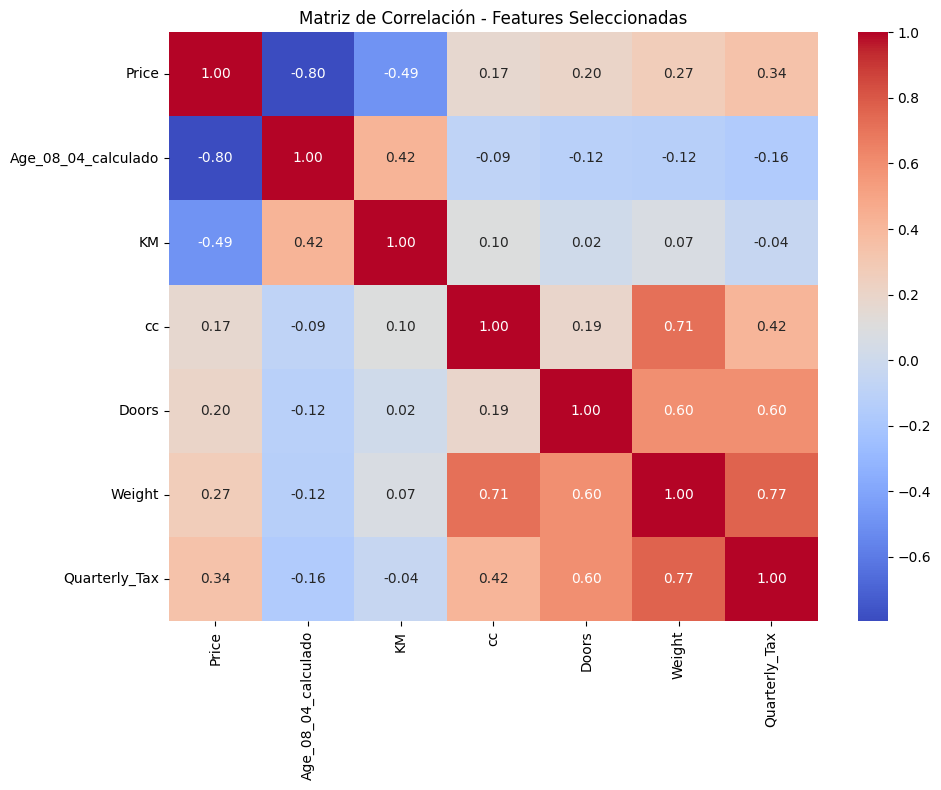

In [24]:
# Correlación (Pearson)
corr_matrix = df_selected.select_dtypes(include=np.number).corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación - Features Seleccionadas')
plt.tight_layout()
plt.show()

In [25]:
# Función para detectar outliers
def detect_outliers(df):
    import numpy as np
    cols = df.select_dtypes(include=np.number).columns
    outliers = pd.DataFrame(columns=['Feature', 'Number of Outliers'])
    for column in cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        n_outliers = df[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]
        outliers = pd.concat(
            [outliers, pd.DataFrame({'Feature': [column], 'Number of Outliers': [n_outliers]})],
            ignore_index=True
        )
    return outliers

outliers_df = detect_outliers(df_selected)
print(outliers_df)

               Feature Number of Outliers
0                Price                  7
1  Age_08_04_calculado                  0
2                   KM                  1
3                   cc                  4
4                Doors                  0
5               Weight                  0
6        Quarterly_Tax                  0


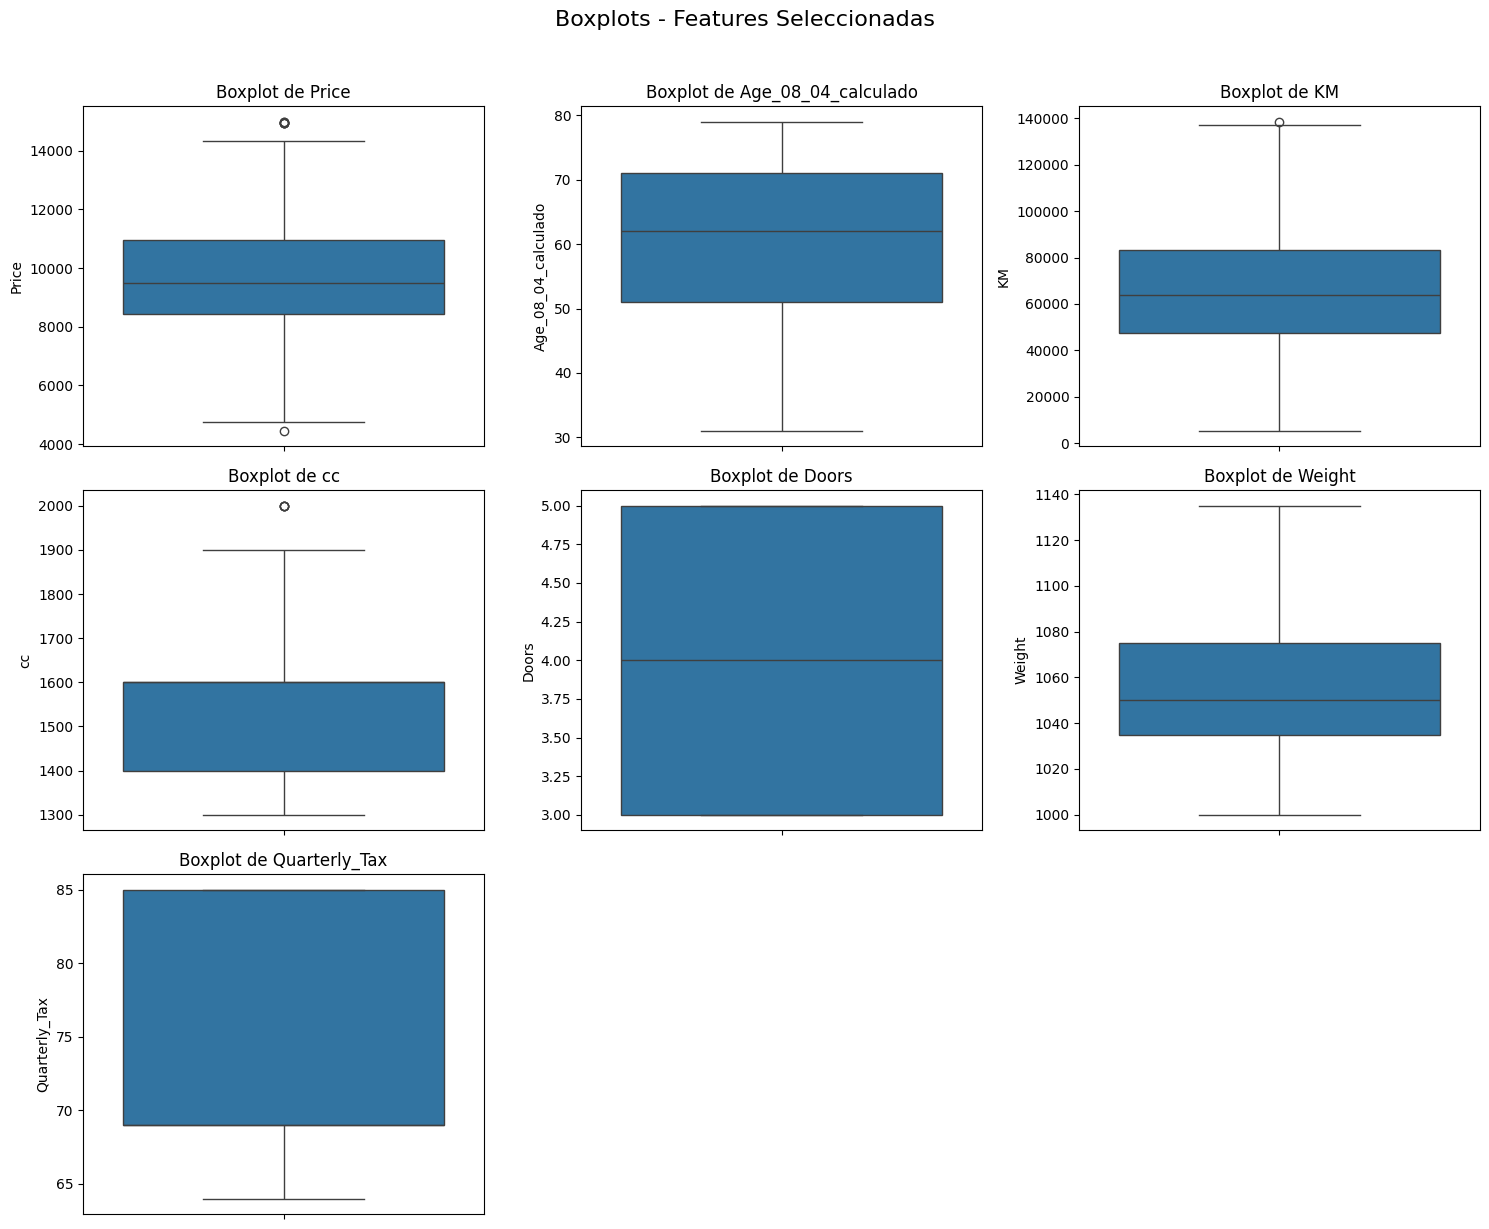

In [26]:
# Boxplots múltiples
import math

num_cols = df_selected.select_dtypes(include=np.number).columns.tolist()
n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, column in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(y=df_selected[column])
    plt.title(f'Boxplot de {column}')
    plt.tight_layout()

plt.suptitle('Boxplots - Features Seleccionadas', fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.tight_layout()
plt.show()

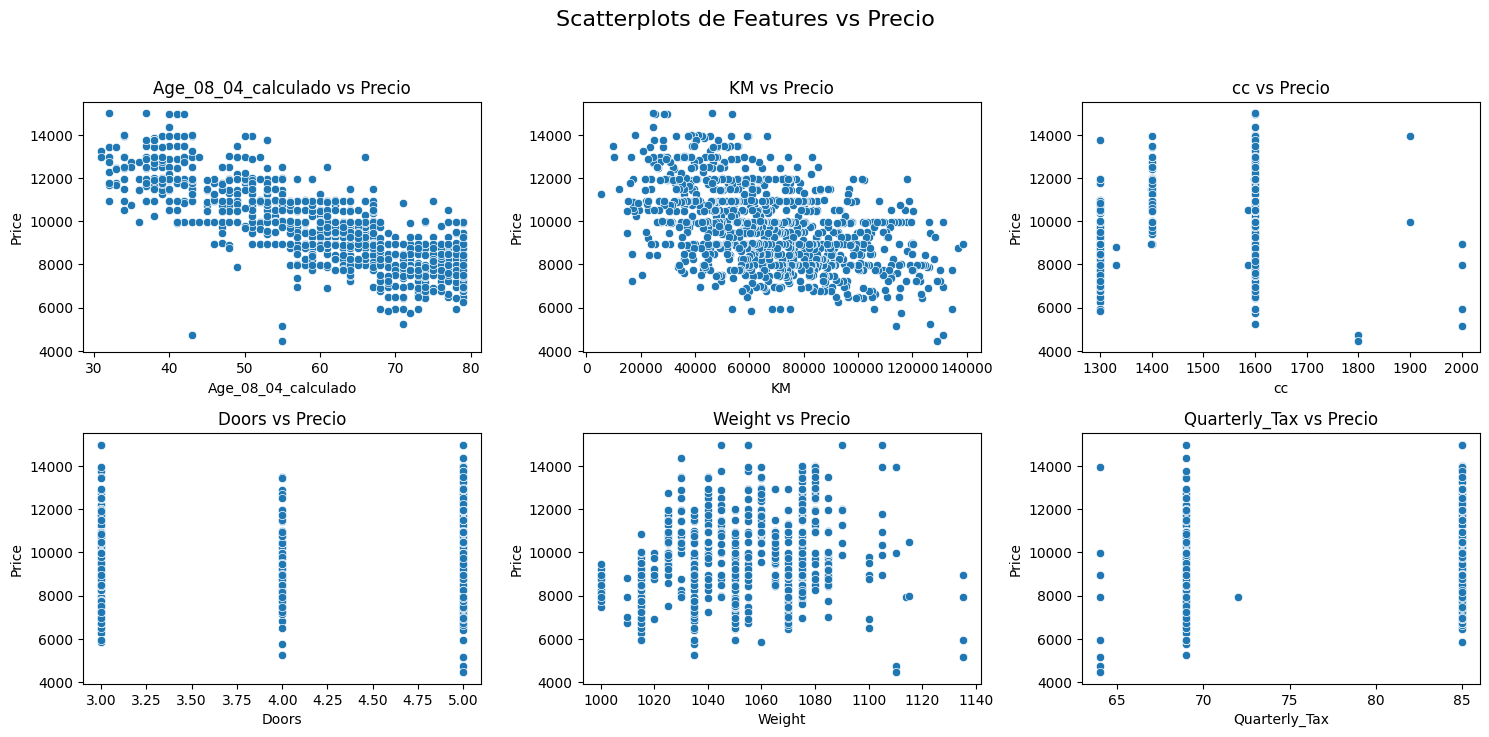

In [ ]:

# Scatterplots
plt.figure(figsize=(15, 10))
for i, column in enumerate([f for f in features_selected if f != "Price"]):
    plt.subplot(3, 3, i + 1)  # 3x3 porque tenés 8 features numéricas
    sns.scatterplot(x=df_selected[column], y=df_selected["Price"])
    plt.title(f'{column} vs Precio')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle('Scatterplots de Features vs Precio', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# 2. PREPROCESAMIENTO
# =========================

# Separar variables
X = df.drop("Price", axis=1)
y = df["Price"]

X = df[features_selected[1:]]  # Excluye 'Price'
y = df["Price"]



# Preprocesamiento
X = pd.get_dummies(X, drop_first=True)           # One-hot encoding
X = X.apply(pd.to_numeric, errors='coerce')      # Forzar datos a numérico
y = pd.to_numeric(y, errors='coerce')            # Lo mismo para el target

# Combinar X e y para eliminar filas con NaNs
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop("Price", axis=1)
y = combined["Price"]

# Convertir a float y agregar constante para OLS
X = X.astype(float)
#y = y.astype(float)
X = sm.add_constant(X)

print(X.head())

   const  Age_08_04_calculado       KM      cc  Doors  Weight  Quarterly_Tax
0    1.0                 22.0  46986.0  2000.0    3.0  1165.0          210.0
1    1.0                 22.0  72937.0  2000.0    3.0  1165.0          210.0
2    1.0                 23.0  41711.0  2000.0    3.0  1165.0          210.0
3    1.0                 25.0  48000.0  2000.0    3.0  1165.0          210.0
4    1.0                 29.0  38500.0  2000.0    3.0  1170.0          210.0


MSE: 2276117.7782320455
MAE: 1017.2385306450402
R2 Score: 0.8294121412776125


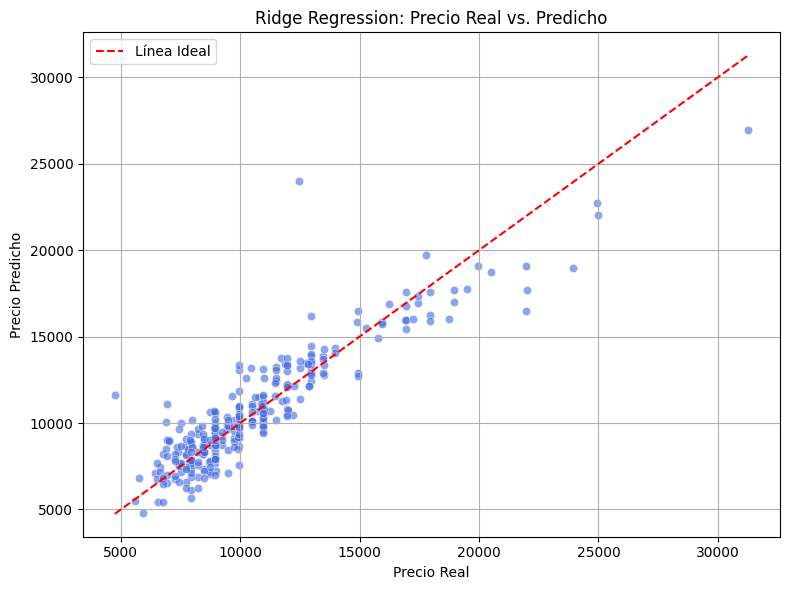

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instanciar modelo Ridge con un alpha (regularización)
ridge = Ridge(alpha=1.0)  # Podés probar distintos valores

# Entrenar
ridge.fit(X_train_scaled, y_train)

# Predecir
y_pred = ridge.predict(X_test_scaled)

# Evaluación
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Gráfico de valores reales vs. predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Línea Ideal")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Ridge Regression: Precio Real vs. Predicho")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

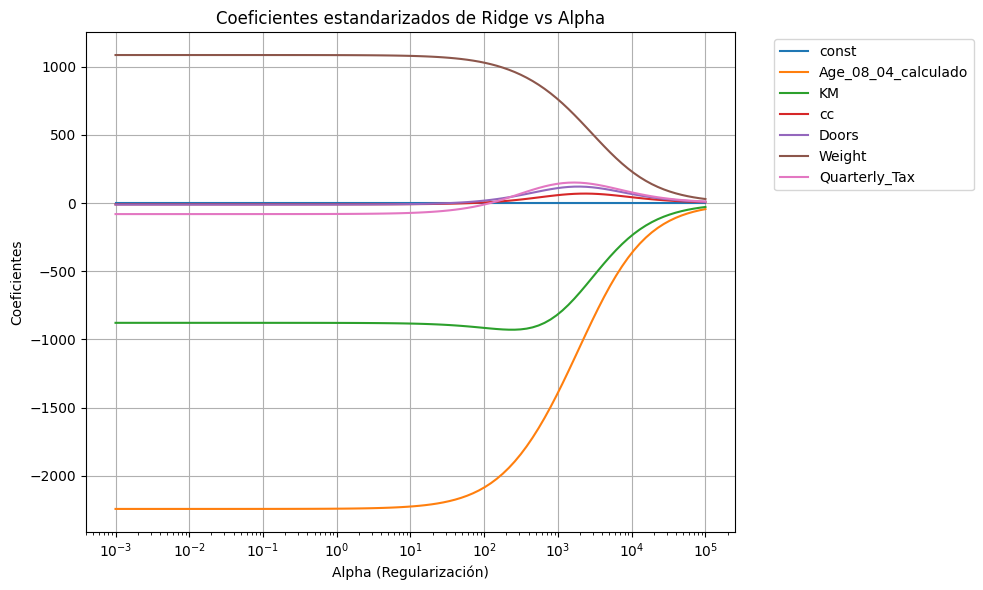

In [30]:
# Estandarizar las features (fundamental para Ridge)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lista de alphas a probar (logspace para cubrir bien el rango)
alphas = np.logspace(-3, 5, 100)

coefs = []

# Entrenar Ridge con cada alpha y guardar coeficientes
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)

# Convertir a DataFrame
coefs = np.array(coefs)

# Gráfico
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=X.columns[i])
    
plt.xscale('log')
plt.xlabel('Alpha (Regularización)')
plt.ylabel('Coeficientes')
plt.title('Coeficientes estandarizados de Ridge vs Alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

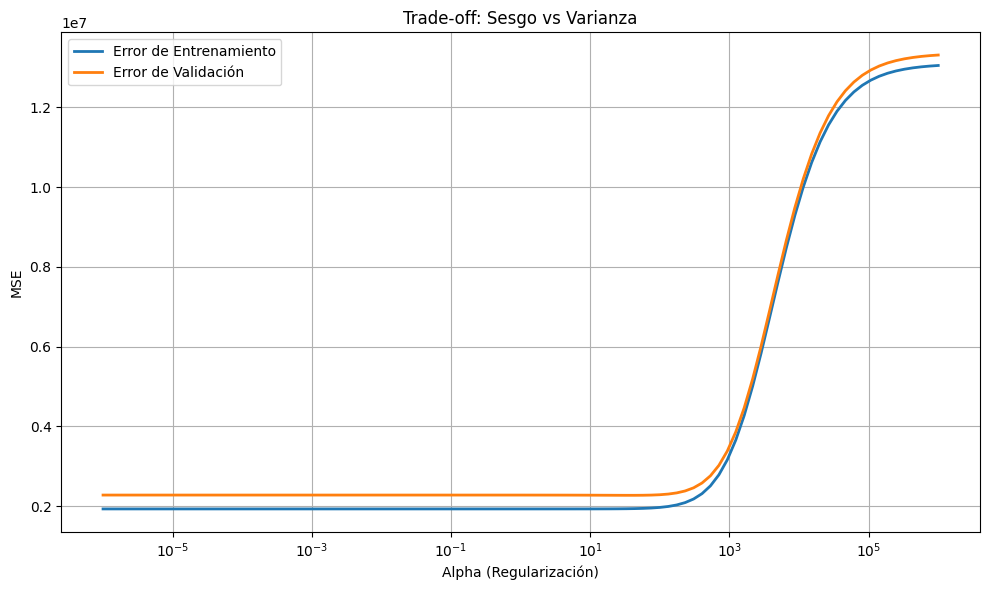

In [31]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Rango de alpha
alphas = np.logspace(-6, 6, 100)

train_errors = []
val_errors = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)

    y_train_pred = ridge.predict(X_train_scaled)
    y_val_pred = ridge.predict(X_val_scaled)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    train_errors.append(train_mse)
    val_errors.append(val_mse)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Error de Entrenamiento', linewidth=2)
plt.plot(alphas, val_errors, label='Error de Validación', linewidth=2)
plt.xscale('log')
plt.xlabel('Alpha (Regularización)')
plt.ylabel('MSE')
plt.title('Trade-off: Sesgo vs Varianza')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1
)

In [33]:
# Iniciar experimento
with mlflow.start_run(run_name="ols_model_run"):
    # Ajustar modelo
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    print(results.summary())

    # Predicciones
    y_pred = results.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    # Log de métricas del modelo statsmodels
    mlflow.log_metric("aic", results.aic)
    mlflow.log_metric("bic", results.bic)
    mlflow.log_metric("df_model", results.df_model)
    mlflow.log_metric("fvalue", results.fvalue)
    mlflow.log_metric("rsquared", results.rsquared)
    mlflow.log_metric("rsquared_adj", results.rsquared_adj)
    mlflow.log_metric("ssr", results.ssr)  # suma de residuos al cuadrado

    # Crear carpeta si no existe
    os.makedirs("mlartifacts", exist_ok=True)

    # Guardar resumen como archivo .txt
    summary_path = os.path.join("mlartifacts", "ols_summary.txt")
    with open(summary_path, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_path)

    # Guardar modelo con joblib
    model_path = os.path.join("mlartifacts", "ols_model.pkl")
    joblib.dump(results, model_path)
    mlflow.log_artifact(model_path)

    # Guardar nombres de features
    features_path = os.path.join("mlartifacts", "features.txt")
    with open(features_path, "w") as f:
        f.write("\n".join(X.columns))
    mlflow.log_artifact(features_path)

print("Modelo OLS registrado con MLflow.")

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     774.2
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        14:29:26   Log-Likelihood:                -7495.5
No. Observations:                 861   AIC:                         1.500e+04
Df Residuals:                     854   BIC:                         1.504e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -340.0062   1